In [117]:
import numpy as np
import os
import subprocess
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
def unit_gaussian(x,mu,sigma):
    inv_cov = np.linalg.inv(sigma)
    D = mu.shape[0]
    exponent = np.exp((-0.5)*np.dot(np.dot((x - mu),inv_cov),(x - mu).T))
    z = 1/(((2*np.pi)**(D/2))*(np.linalg.det(sigma)**0.5))
    return z*exponent

def calculate_likelihood(N,K,data,mu_k,cov_k,pi_k):
    log_likelihood = 0
    for n in range(N):
        temp = 0
        for k in range(K):
            temp += pi_k[k] * (unit_gaussian(data[n],mu_k[k,:],cov_k[k,:,:]))
        log_likelihood += np.log(temp)
    return log_likelihood

def testing_model(MAP_ADAPTED_MODEL,test_array,index1,index2,D = 13,K = 32):
    mu_map,cov_map,pi_map = MAP_ADAPTED_MODEL["mean"],MAP_ADAPTED_MODEL["cov"],MAP_ADAPTED_MODEL["pi"]
    if len(test_array[index1:index2]) == 1500:
        return calculate_likelihood(1500,K,np.array(test_array[index1:index2]),mu_map,cov_map,pi_map)
    else:
        print("not enough data points")
        
def load_csv_file(file_path):
    array = []
    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file)
        for e in csv_reader:
            array.append(e)
    return np.array(array,dtype = np.float64),len(array)

def load_map_model(map_file_path):
    return np.load(map_file_path).item()

def check_name(list_of_strings,file_name_string):
    for e in list_of_strings:
        if e in file_name_string:
            return True
    return False

In [3]:
ROOT_TESTING_FOLDER = "/Users/siva/Documents/speaker_recognition/DHI_audio_files/converted_16k_voice_samples_with_mfcc"
ROOT_MODELS_FOLDER = "/Users/siva/Documents/speaker_recognition/numpy_files/new_models_for_results"
NO_OF_DATAPOINTS = 1500

In [4]:
all_test_files = []
for root,dirs,files in os.walk(ROOT_TESTING_FOLDER):
    if files != []:
        for file in files:
            if ".csv" in file:
                all_test_files.append(root+"/"+file)

In [5]:
all_models = []
for root,dirs,files in os.walk(ROOT_MODELS_FOLDER):
    if files != []:
        for file in files:
            all_models.append(root+"/"+file)

In [6]:
testing_results = {"model":[],"testing_file":[],"index1":[],"index2":[],"likelihood":[]}
for each_model in all_models:
    map_model = load_map_model(each_model)
    print("*****************************")
    print("TESTING MODEL:",each_model)
    for each_test_file in all_test_files:
        test_file,len_ = load_csv_file(each_test_file)
        no_of_splits = len_//NO_OF_DATAPOINTS
        for i in range(0,no_of_splits):
            likelihood = testing_model(map_model,test_file,i*NO_OF_DATAPOINTS,(i+1)*NO_OF_DATAPOINTS)
            print("testing file:",each_test_file.split("/")[-1],"index {0}-{1}".format(i*NO_OF_DATAPOINTS,(i+1)*NO_OF_DATAPOINTS),\
                 "likelihood:",likelihood)
            testing_results["model"].append(each_model)
            testing_results["testing_file"].append(each_test_file)
            testing_results["index1"].append(i*NO_OF_DATAPOINTS)
            testing_results["index2"].append((i+1)*NO_OF_DATAPOINTS)
            testing_results["likelihood"].append(likelihood)

*****************************
TESTING MODEL: /Users/siva/Documents/speaker_recognition/numpy_files/new_models_for_results/lin_new_10000.npy
testing file: Jourdon_training_baseline_close.csv index 0-1500 likelihood: [-129329.2563718]
testing file: Jourdon_training_baseline_close.csv index 1500-3000 likelihood: [-135378.86811802]
testing file: Jourdon_training_baseline_close.csv index 3000-4500 likelihood: [-133352.17381548]
testing file: Jourdon_training_baseline_close.csv index 4500-6000 likelihood: [-135945.50166592]
testing file: Jourdon_training_baseline_close.csv index 6000-7500 likelihood: [-142442.74105524]
testing file: Jourdon_training_baseline_close.csv index 7500-9000 likelihood: [-151997.41810179]
testing file: Jourdon_training_baseline_close.csv index 9000-10500 likelihood: [-151447.01597465]
testing file: Jourdon_training_baseline_close.csv index 10500-12000 likelihood: [-151719.85946069]
testing file: rapid_speech_jourdan.csv index 0-1500 likelihood: [-131274.23715224]
te

In [7]:
np.save("DHI_testing_results.npy",testing_results)

In [153]:
def generate_confusion_matrix(results,model_name,file_name_strings,file_name_exceptions):
    positive_likelihood_values = {}
    negative_likelihood_values = {}
    for model,file,likelihood in zip(results["model"],results["testing_file"],\
                                     results["likelihood"]):
        file_ = file.split("/")[-1]
        model_ = model.split("/")[-1]
        if model_ == model_name:
            if check_name(file_name_strings,file_):
                if not check_name(file_name_exceptions,file_):
                    #print(file_)
                    positive_likelihood_values[abs(likelihood[0])] = file_
                #else:
                    #print(file_)
            else:
                negative_likelihood_values[abs(likelihood[0])] = file_
    mean = np.mean(list(positive_likelihood_values.keys()))
    TP = sum(list(positive_likelihood_values.keys())<mean)
    TN = sum(list(negative_likelihood_values.keys())>mean)
    FP = sum(list(negative_likelihood_values.keys())<mean)
    FN = sum(list(positive_likelihood_values.keys())>mean)
    arr = [[TP,FP],[FN,TN]]
    s = [["TP","FP"],["FN","TN"]]
    plt.imshow(arr, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(arr[i][j]))
    print("mean:",mean,"TP:",TP,"TN:",TN,"FP:",FP,"FN:",FN,"Accuracy:",np.sum(np.diag(arr))/np.sum(arr))

mean: 74168.7048373 TP: 13 TN: 282 FP: 0 FN: 11 Accuracy: 0.964052287582


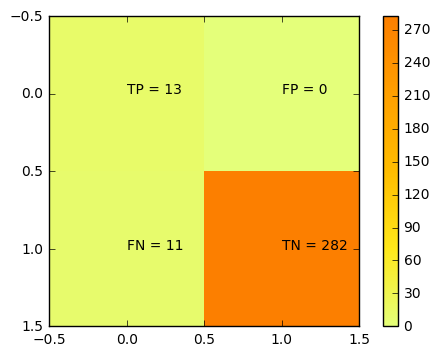

In [154]:
generate_confusion_matrix(testing_results,"lin_new_10000.npy",["LB","Lin"],["training","baseline","close"])

mean: 75031.3006428 TP: 21 TN: 259 FP: 4 FN: 20 Accuracy: 0.921052631579


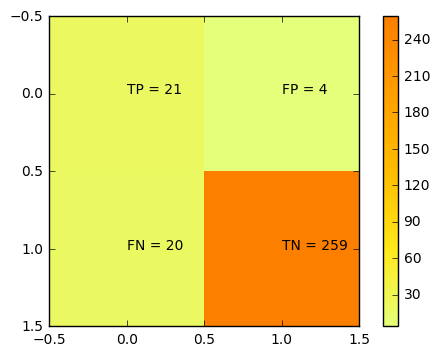

In [155]:
generate_confusion_matrix(testing_results,"mariah_new_10000.npy",["Mariah"],["training","Baseline","Close"])

mean: 74610.5095023 TP: 9 TN: 297 FP: 0 FN: 6 Accuracy: 0.980769230769


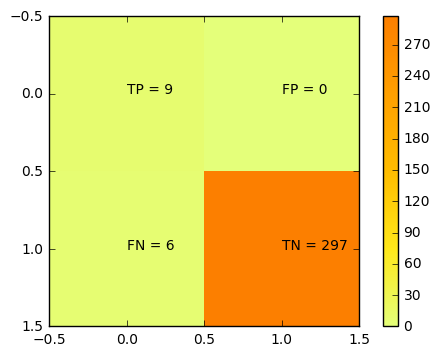

In [156]:
generate_confusion_matrix(testing_results,"ew_new_10000.npy",["EW"],["sample_1"])

mean: 76969.941595 TP: 9 TN: 262 FP: 29 FN: 7 Accuracy: 0.882736156352


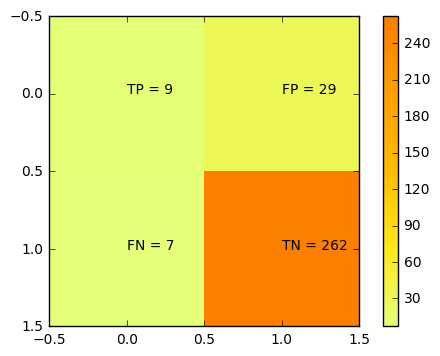

In [157]:
generate_confusion_matrix(testing_results,"kara_new_10000.npy",["Kara"],["Baseline","Close","training"])

mean: 116992.612935 TP: 4 TN: 101 FP: 190 FN: 9 Accuracy: 0.345394736842


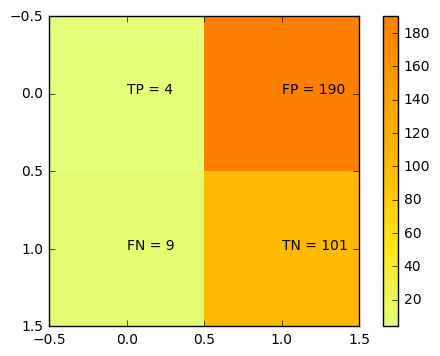

In [158]:
generate_confusion_matrix(testing_results,"cindy_new_10000.npy",["Cindy"],["Baseline","Close","training"])

mean: 75047.9095684 TP: 8 TN: 288 FP: 0 FN: 8 Accuracy: 0.973684210526


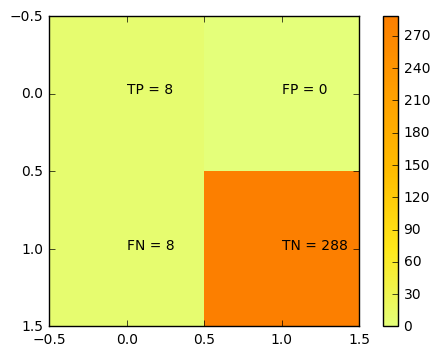

In [159]:
generate_confusion_matrix(testing_results,"samarth_new_10000.npy",["Samarth"],["soft","close","training"])

mean: 78381.3612369 TP: 12 TN: 190 FP: 90 FN: 12 Accuracy: 0.664473684211


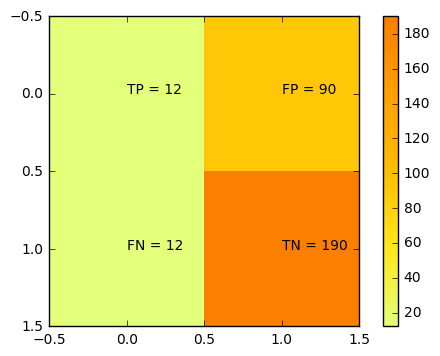

In [160]:
generate_confusion_matrix(testing_results,"jourdon_new_10000.npy",["Jourdon","jourdan"],["baseline","close","training"])

mean: 73216.6479664 TP: 10 TN: 291 FP: 0 FN: 6 Accuracy: 0.980456026059


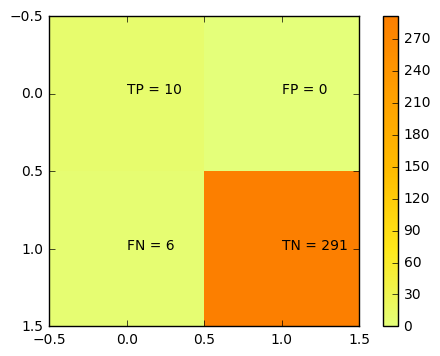

In [161]:
generate_confusion_matrix(testing_results,"arti_new_10000.npy",["AG","Arti"],["Baseline","close","training"])

mean: 73593.0159238 TP: 16 TN: 277 FP: 0 FN: 14 Accuracy: 0.954397394137


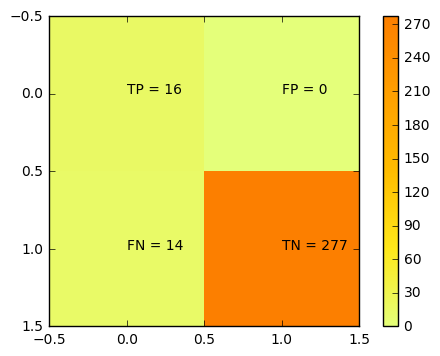

In [162]:
generate_confusion_matrix(testing_results,"anne_new_10000.npy",["Anne"],["baseline","close","training"])